In [2]:
# przetwarzanie danych
import numpy as np
import pandas as pd

# przekształcanie – normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# wizualizacja
import matplotlib.pyplot as plt

# sieci neuronowe
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

# ewaluacja modelu
from sklearn.metrics import mean_squared_error

In [3]:
dataset = pd.read_csv('airline-passengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index(['Month'], inplace=True)
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


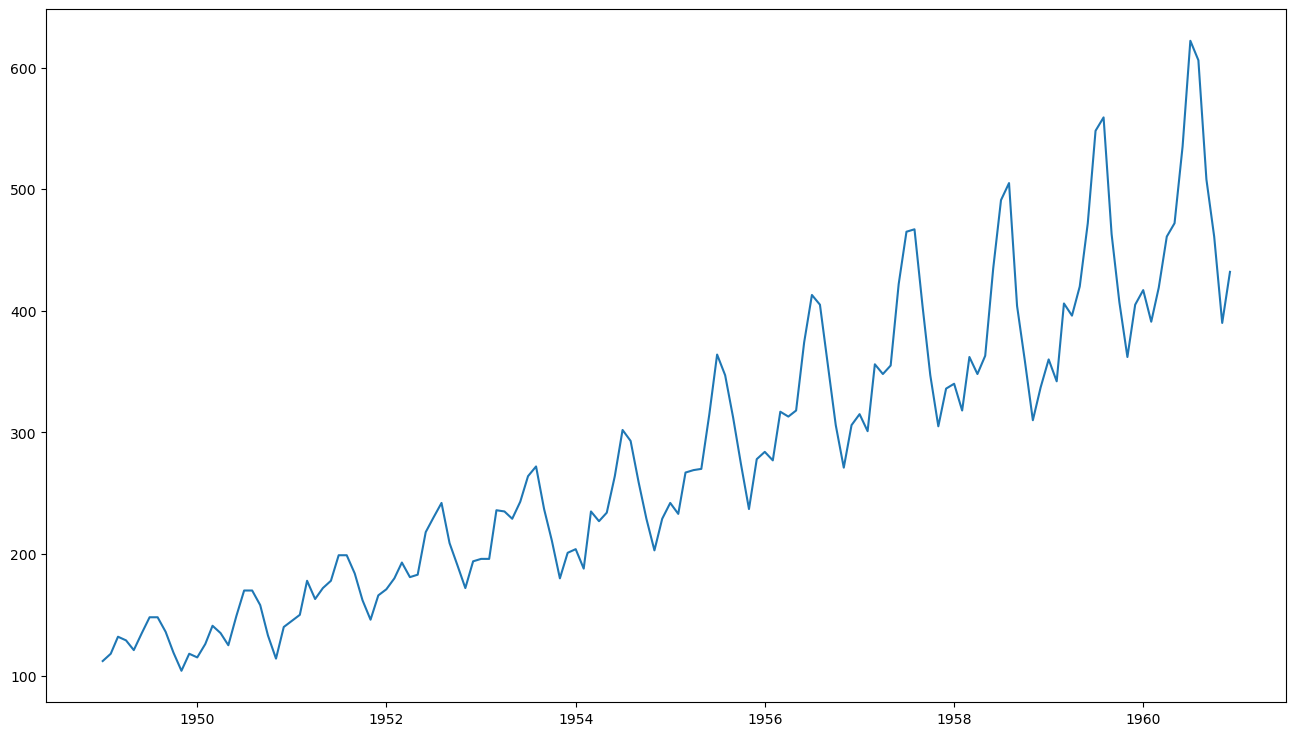

In [4]:
plt.figure(figsize=(16,9))
plt.plot(dataset['Passengers'])
plt.show()

In [5]:
train_size = int(len(dataset) * 0.70)
scaler = MinMaxScaler(feature_range=(0, 1))

def create_dataset(df, train_size, lback=3, scaler_function=scaler):
    test_size = len(df) - train_size
    train, test = df[0:train_size,:].copy(), df[train_size:len(df),:].copy()
    train = scaler_function.fit_transform(train)
    test = scaler_function.transform(test)
    X_train, X_test, y_train, y_test = [], [], [], []

    # Tworzenie zbioru treninowego
    for i in range(len(train)-lback-1):
        a = train[i:(i+lback), 0]
        X_train.append(a)
        y_train.append(train[i + lback, 0])

    # Tworzenie zbioru testowego
    for i in range(lback):
        a = train[len(train) - lback + i :, 0]
        j = 0
        while len(a)!=lback:
            a = np.append(a, test[j])
            j+=1
        X_test.append(a)
        y_test.append(test[i, 0])
        
    for i in range(len(test)-lback-1):
        a = test[i:(i+lback), 0]
        X_test.append(a)
        y_test.append(test[i + lback, 0])

    X_train, X_test = np.array(X_train), np.array(X_test)
    X_train, X_test = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    y_train, y_test = np.array(y_train), np.array(y_test)
    return X_train, X_test, y_train, y_test

In [6]:
def backtests(model, lback=3):

    # predykcja - train
    prediction_train = scaler.inverse_transform(model.predict(X_train))
    prediction_train = pd.Series(prediction_train.flatten(),
                                index=dataset.index[lback-1:len(prediction_train)+lback-1])

    # predykcja - test
    prediction_test = scaler.inverse_transform(model.predict(X_test))
    prediction_test = pd.Series(prediction_test.flatten(),
                                index=dataset.index[len(prediction_train)+lback:len(dataset)-2])

    # obliczenie RMSE
    rmse = mean_squared_error(dataset.loc[prediction_test.index, :], prediction_test) ** 0.5
    
    return prediction_train, prediction_test, rmse

In [7]:
def pred_visualization(prediction_train, prediction_test):
    plt.figure(figsize=(16,9))
    plt.plot(dataset['Passengers'], color='blue', label='True values')
    plt.plot(prediction_train, color='green', label='Prediction - Train')
    plt.plot(prediction_test, color='red', label='Prediction - Test')
    plt.legend(loc='upper left')
    plt.show()

## RNN

In [14]:
import warnings
warnings.filterwarnings("ignore")

params_dict = {}

for i in range(1,13):
    X_train, X_test, y_train, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=i)

    for j in range(1,13):
        model_rnn = Sequential()
        model_rnn.add(SimpleRNN(j, input_shape=(1, i)))
        model_rnn.add(Dense(1))
        model_rnn.compile(loss='mean_squared_error', optimizer='adam')
        model_rnn.fit(X_train, y_train, epochs=200, validation_split=0.1, batch_size=1, verbose=0)
        prediction_train, prediction_test, rmse = backtests(model_rnn, i)
        params_dict[rmse] = (prediction_train, prediction_test, i, j)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000016ABC634B80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━

In [16]:
print(f'\nRMSE TEST: {min(params_dict.keys())}')


RMSE TEST: 32.53741503057809


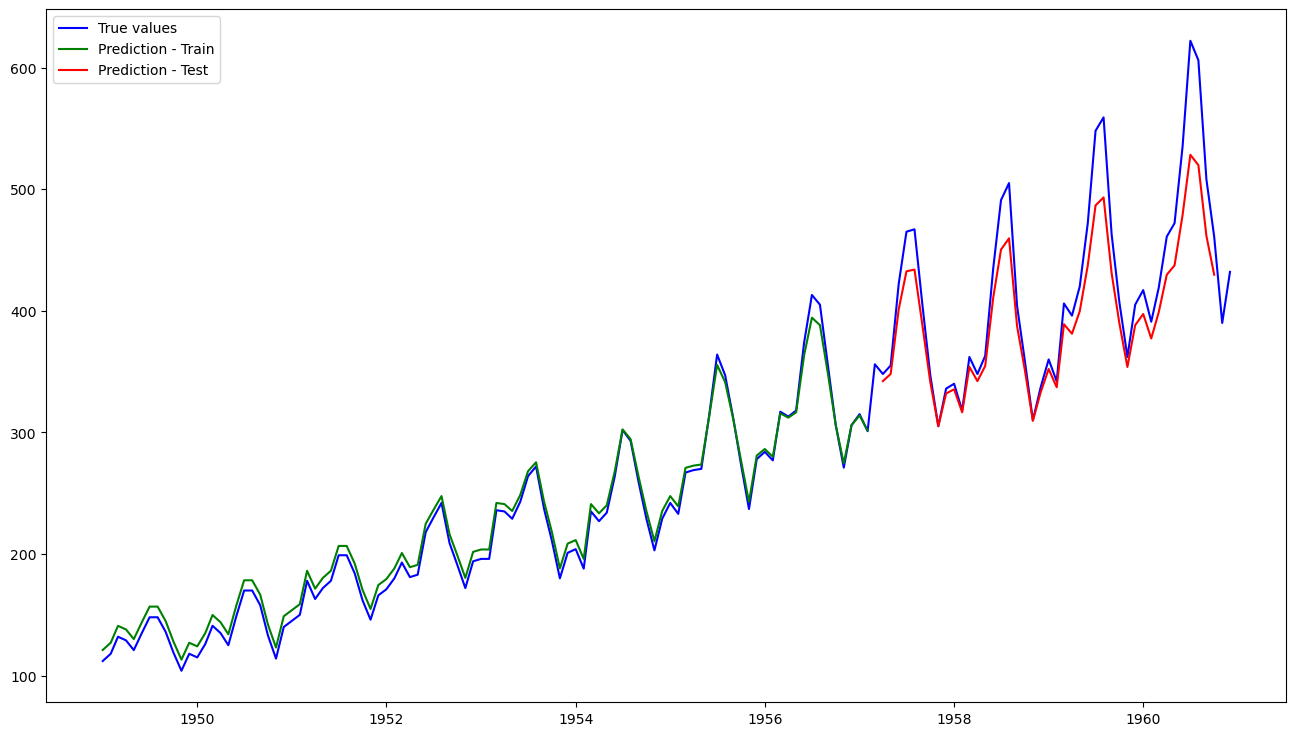

In [18]:
pred_visualization(params_dict[min(params_dict.keys())][0], params_dict[min(params_dict.keys())][1])

## LSTM

In [9]:
import warnings
warnings.filterwarnings("ignore")

params_dict = {}

for i in range(1,13):
    X_train, X_test, y_train, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=i)

    for j in range(1,13):
        model_lstm = Sequential()
        model_lstm.add(LSTM(j, input_shape=(1, i)))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mean_squared_error', optimizer='adam')
        model_lstm.fit(X_train, y_train, epochs=200, validation_split=0.1, batch_size=1, verbose=0)
        prediction_train, prediction_test, rmse = backtests(model_lstm, i)
        params_dict[rmse] = (prediction_train, prediction_test, i, j)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A86CC65EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━

In [17]:
print(f'\nRMSE TEST: {min(params_dict.keys())}')


RMSE TEST: 30.098787112353307


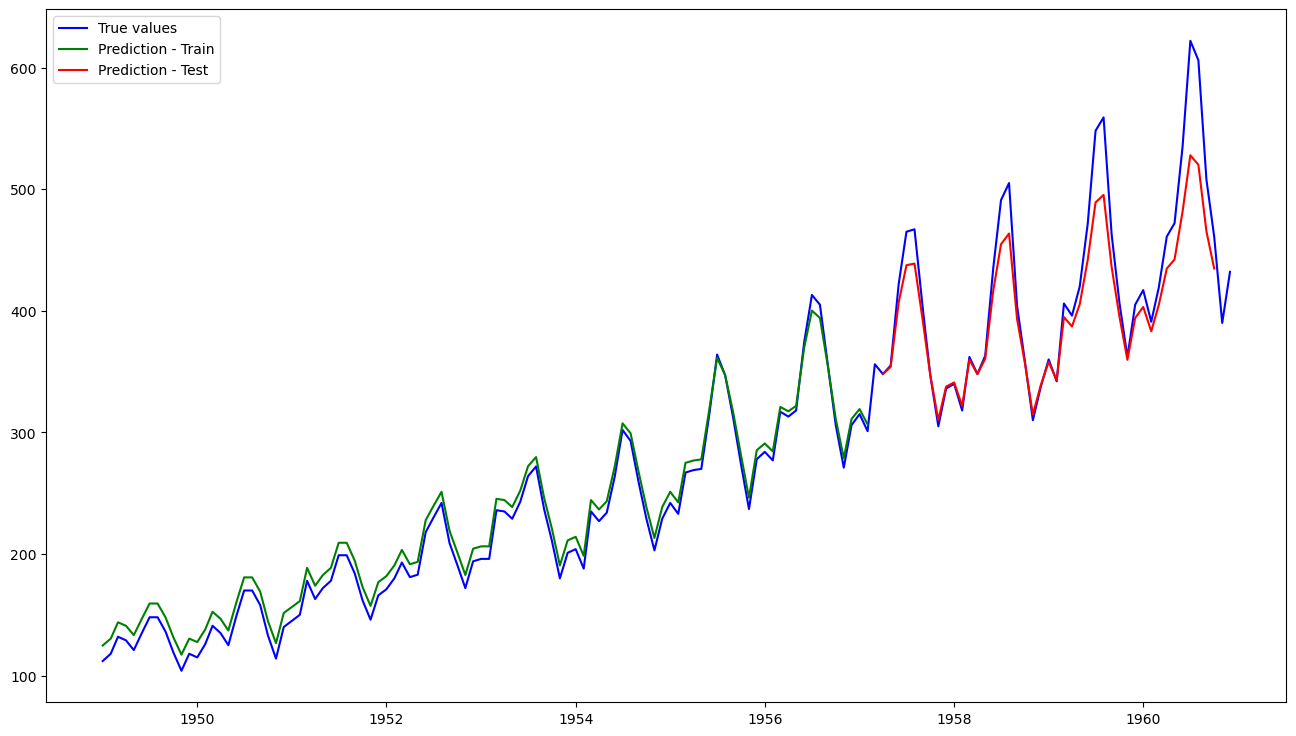

In [19]:
pred_visualization(params_dict[min(params_dict.keys())][0], params_dict[min(params_dict.keys())][1])

## GRU

In [28]:
params_dict = {}

for i in range(1,13):
    X_train, X_test, y_train, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=i)

    for j in range(1,13):
        model_gru = Sequential()
        model_gru.add(GRU(j, input_shape=(1, i)))
        model_gru.add(Dense(1))
        model_gru.compile(loss='mean_squared_error', optimizer='adam')
        model_gru.fit(X_train, y_train, epochs=200, validation_split=0.1, batch_size=1, verbose=0)
        prediction_train, prediction_test, rmse = backtests(model_gru, i)
        params_dict[rmse] = (prediction_train, prediction_test, i, j)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

In [30]:
print(f'\nRMSE TEST: {min(params_dict.keys())}')


RMSE TEST: 30.89263918952791


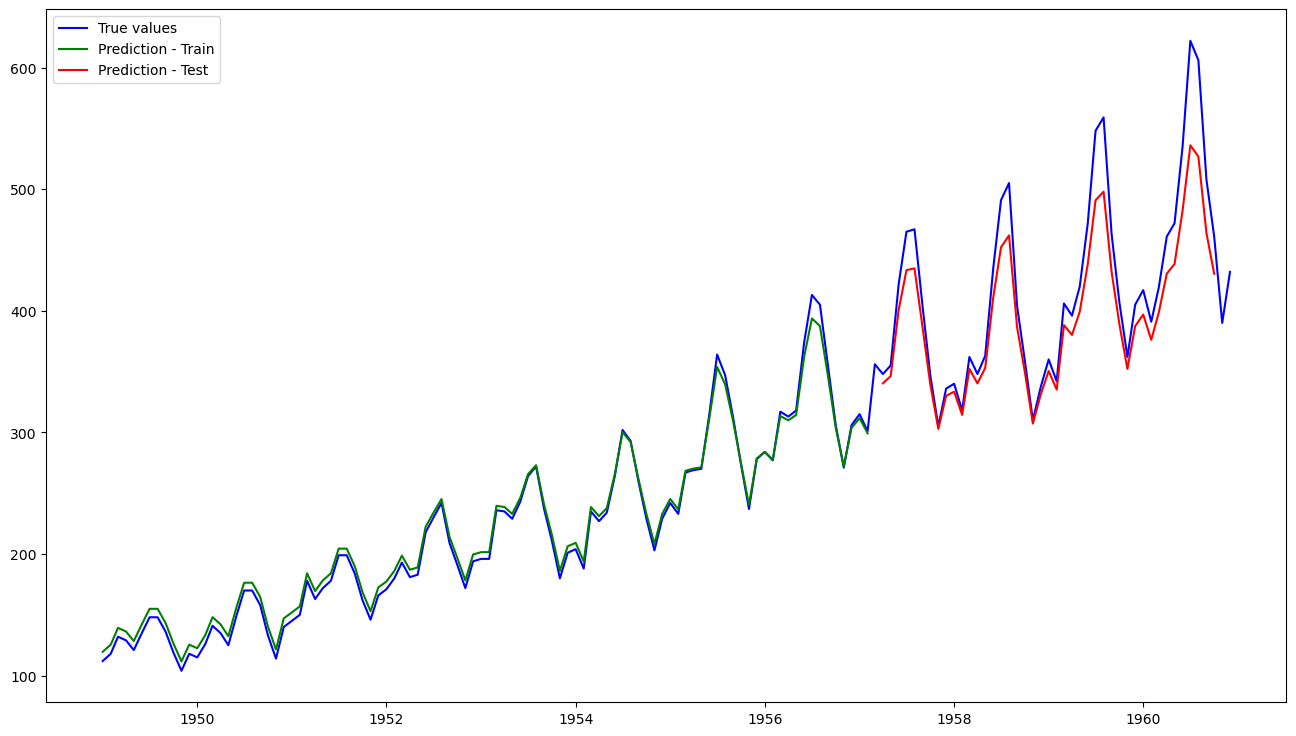

In [32]:
pred_visualization(params_dict[min(params_dict.keys())][0], params_dict[min(params_dict.keys())][1])